In [1]:
# =========================
# INSTALL DEPENDENCIES
# =========================
!pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0 \
 --extra-index-url https://download.pytorch.org/whl/cu121

!pip uninstall numpy -y
!pip install numpy==1.26.4

!pip install \
    torch-scatter \
    torch-sparse \
    torch-cluster \
    torch-spline-conv \
    -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

!pip install torch-geometric open3d tqdm


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.4 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
Defaulting to user installation becaus

In [44]:
import os, glob, torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import open3d as o3d
from torch.utils.data import Dataset, DataLoader

# Provided Config
DATA_DIR = "/home/exouser/02_triangular_mesh_autoencoder/Dataset/FielGrwon_ZeaMays_RawPCD_10k"
NUM_POINTS = 10000
BATCH_SIZE = 4 
EPOCHS = 1500
K = 16
LATENT_DIM = 256 # Higher latent dim helps with complex maize leaves
LR = 3E-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

Using device: cuda


In [45]:
def chamfer_loss(p1, p2):
    """
    p1: [B, N, 3] (Predicted)
    p2: [B, M, 3] (Ground Truth)
    """
    # Calculate squared distance matrix
    # (x-y)^2 = x^2 - 2xy + y^2
    p1_sq = torch.sum(p1**2, dim=-1).unsqueeze(-1) # [B, N, 1]
    p2_sq = torch.sum(p2**2, dim=-1).unsqueeze(1)  # [B, 1, M]
    dist = p1_sq - 2 * torch.matmul(p1, p2.transpose(1, 2)) + p2_sq # [B, N, M]
    
    # Distance from each point in p1 to nearest in p2
    loss_p1 = torch.mean(torch.min(dist, dim=2)[0])
    # Distance from each point in p2 to nearest in p1
    loss_p2 = torch.mean(torch.min(dist, dim=1)[0])
    
    return loss_p1 + loss_p2

In [46]:
class MaizeDataset(Dataset):
    def __init__(self, root_dir, num_points=2096):
        self.file_list = glob.glob(os.path.join(root_dir, "*.ply"))
        self.num_points = num_points

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        pcd = o3d.io.read_point_cloud(self.file_list[idx])
        points = np.asarray(pcd.points)
        
        # Resample
        indices = np.random.choice(len(points), self.num_points, 
                                 replace=True if len(points) < self.num_points else False)
        points = points[indices].astype(np.float32)
        
        # Center and Normalize
        points -= np.mean(points, axis=0)
        scale = np.max(np.linalg.norm(points, axis=1))
        points /= (scale + 1e-6)
        
        return torch.FloatTensor(points)

dataloader = DataLoader(MaizeDataset(DATA_DIR), batch_size=BATCH_SIZE, shuffle=True)

In [47]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(3, 64, 1), nn.BatchNorm1d(64), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv1d(64, 128, 1), nn.BatchNorm1d(128), nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv1d(256, latent_dim, 1), nn.BatchNorm1d(latent_dim), nn.ReLU())

    def forward(self, x):
        x = x.transpose(2, 1) # [B, 3, N]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return torch.max(x, 2)[0] # Global Feature Vector

class Decoder(nn.Module):
    def __init__(self, latent_dim, num_points):
        super().__init__()
        self.n = num_points
        # 2D Grid Template
        grid_size = int(np.sqrt(num_points)) + 1
        grid = np.meshgrid(np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size))
        grid = np.stack(grid, axis=-1).reshape(-1, 2)[:num_points]
        self.register_buffer('grid', torch.FloatTensor(grid).unsqueeze(0))

        self.fold1 = nn.Sequential(
            nn.Linear(latent_dim + 2, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 3)
        )
        self.fold2 = nn.Sequential(
            nn.Linear(latent_dim + 3, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 3)
        )

    def forward(self, latent):
        batch_size = latent.size(0)
        x = latent.unsqueeze(1).repeat(1, self.n, 1) # [B, N, Latent]
        grid = self.grid.repeat(batch_size, 1, 1)
        
        pc1 = self.fold1(torch.cat([x, grid], dim=2))
        pc2 = self.fold2(torch.cat([x, pc1], dim=2))
        return pc2

In [48]:
import os

# Define the save path
CHECKPOINT_DIR = "/home/exouser/02_triangular_mesh_autoencoder/checkpoints/gcn_AE"

# Create the directory if it doesn't exist
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
    print(f"Created directory: {CHECKPOINT_DIR}")

encoder = Encoder(LATENT_DIM).to(DEVICE)
decoder = Decoder(LATENT_DIM, NUM_POINTS).to(DEVICE)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LR)

best_loss = float('inf')

print("Training with Chamfer Loss and Checkpointing...")
for epoch in range(1, EPOCHS + 1):
    encoder.train()
    decoder.train()
    total_loss = 0
    
    for points in dataloader:
        points = points.to(DEVICE)
        optimizer.zero_grad()
        
        latent = encoder(points)
        recon = decoder(latent)
        
        loss = chamfer_loss(recon, points)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    
    # Print progress every 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{EPOCHS} | Chamfer Loss: {avg_loss:.6f}")
    
    # --- CHECKPOINT LOGIC ---
    
    # 1. Save every 100 epochs
    if epoch % 100 == 0:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"maize_ae_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"---> Saved checkpoint at epoch {epoch}: {checkpoint_path}")

    # 2. Save the BEST model (lowest loss) regardless of epoch count
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_path = os.path.join(CHECKPOINT_DIR, "best_maize_model.pth")
        torch.save({
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'loss': best_loss,
        }, best_path)

Training with Chamfer Loss and Checkpointing...


Epoch 1/1500 | Chamfer Loss: 0.134358
Epoch 10/1500 | Chamfer Loss: 0.011333
Epoch 20/1500 | Chamfer Loss: 0.006925
Epoch 30/1500 | Chamfer Loss: 0.005689
Epoch 40/1500 | Chamfer Loss: 0.004043
Epoch 50/1500 | Chamfer Loss: 0.003889
Epoch 60/1500 | Chamfer Loss: 0.003113
Epoch 70/1500 | Chamfer Loss: 0.002968
Epoch 80/1500 | Chamfer Loss: 0.002893
Epoch 90/1500 | Chamfer Loss: 0.002428
Epoch 100/1500 | Chamfer Loss: 0.002484
---> Saved checkpoint at epoch 100: /home/exouser/02_triangular_mesh_autoencoder/checkpoints/gcn_AE/maize_ae_epoch_100.pth
Epoch 110/1500 | Chamfer Loss: 0.002305
Epoch 120/1500 | Chamfer Loss: 0.002130
Epoch 130/1500 | Chamfer Loss: 0.002160
Epoch 140/1500 | Chamfer Loss: 0.002003
Epoch 150/1500 | Chamfer Loss: 0.002046
Epoch 160/1500 | Chamfer Loss: 0.001902
Epoch 170/1500 | Chamfer Loss: 0.001808
Epoch 180/1500 | Chamfer Loss: 0.001776
Epoch 190/1500 | Chamfer Loss: 0.001925
Epoch 200/1500 | Chamfer Loss: 0.001699
---> Saved checkpoint at epoch 200: /home/exouse

In [40]:
def save_reconstruction(model_enc, model_dec, input_ply, output_name):
    pcd = o3d.io.read_point_cloud(input_ply)
    pts = np.asarray(pcd.points)
    pts -= np.mean(pts, axis=0)
    pts /= np.max(np.linalg.norm(pts, axis=1))
    
    # Take first NUM_POINTS
    if pts.shape[0] > NUM_POINTS: pts = pts[:NUM_POINTS]
    input_ts = torch.FloatTensor(pts).unsqueeze(0).to(DEVICE)

    model_enc.eval(); model_dec.eval()
    with torch.no_grad():
        recon = model_dec(model_enc(input_ts)).cpu().squeeze(0).numpy()
    
    out_pcd = o3d.geometry.PointCloud()
    out_pcd.points = o3d.utility.Vector3dVector(recon)
    o3d.io.write_point_cloud(output_name, out_pcd)
    print(f"Reconstruction saved to: {output_name}")

# Run for a sample
test_sample = glob.glob(os.path.join(DATA_DIR, "*.ply"))[0]
save_reconstruction(encoder, decoder, test_sample, "maize_chamfer_result1.ply")

Reconstruction saved to: maize_chamfer_result1.ply


Successfully loaded model from /home/exouser/02_triangular_mesh_autoencoder/checkpoints/gcn_AE/best_maize_model.pth


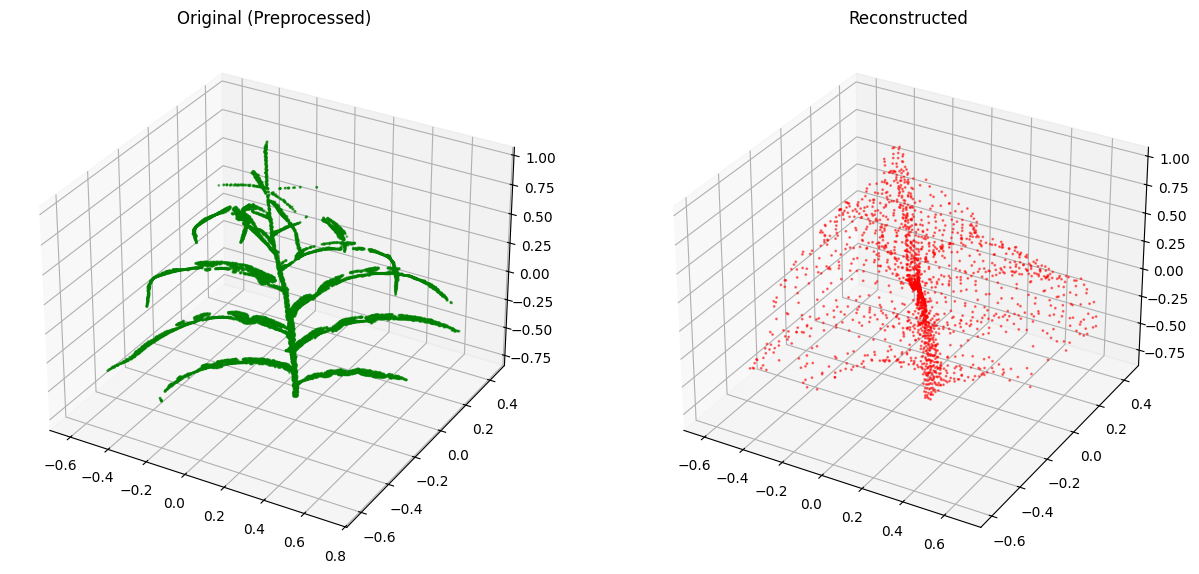

Saved reconstructed output to reconstructed_output.ply


In [49]:
import torch
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Setup paths
CHECKPOINT_PATH = "/home/exouser/02_triangular_mesh_autoencoder/checkpoints/gcn_AE/best_maize_model.pth"
TEST_PLY_FILE = "/home/exouser/02_triangular_mesh_autoencoder/Dataset/FielGrwon_ZeaMays_RawPCD_10k/0068.ply" # Change to an existing filename

# 2. Re-initialize architectures (ensure these match your training classes)
encoder = Encoder(LATENT_DIM).to(DEVICE)
decoder = Decoder(LATENT_DIM, NUM_POINTS).to(DEVICE)

# 3. Load the saved weights
if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    print(f"Successfully loaded model from {CHECKPOINT_PATH}")
else:
    print("Checkpoint file not found!")

def perform_reconstruction(model_enc, model_dec, file_path):
    # Set to evaluation mode
    model_enc.eval()
    model_dec.eval()
    
    # Load and preprocess the PLY
    pcd = o3d.io.read_point_cloud(file_path)
    points = np.asarray(pcd.points)
    
    # Resample to match NUM_POINTS used in training
    indices = np.random.choice(len(points), NUM_POINTS, 
                             replace=True if len(points) < NUM_POINTS else False)
    points = points[indices].astype(np.float32)
    
    # Normalize (Must match training normalization precisely)
    centroid = np.mean(points, axis=0)
    points -= centroid
    scale = np.max(np.linalg.norm(points, axis=1))
    points /= (scale + 1e-6)
    
    # Convert to Tensor
    input_tensor = torch.FloatTensor(points).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        # Encode to latent space
        latent_vector = model_enc(input_tensor)
        # Decode to 3D points
        reconstructed_points = model_dec(latent_vector)
    
    return points, reconstructed_points.squeeze(0).cpu().numpy()

# 4. Run Reconstruction
original, reconstructed = perform_reconstruction(encoder, decoder, TEST_PLY_FILE)

# 5. Visualize the result
fig = plt.figure(figsize=(15, 7))

# Ground Truth
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(original[:, 0], original[:, 1], original[:, 2], s=1, c='green', alpha=0.5)
ax1.set_title("Original (Preprocessed)")

# Reconstruction
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], s=1, c='red', alpha=0.5)
ax2.set_title("Reconstructed")

plt.show()

# 6. Save as a new PLY file
recon_pcd = o3d.geometry.PointCloud()
recon_pcd.points = o3d.utility.Vector3dVector(reconstructed)
o3d.io.write_point_cloud("reconstructed_output.ply", recon_pcd)
print("Saved reconstructed output to reconstructed_output.ply")